# Relative Orientation Computation
This notebook is meant to be used to debug the computations associated with the determination of relative orientation between two images in the model space. This approach uses the collinearity equations to establish the relationship between points common to both images, and constructs a linearized model of the relationship using analytically computed derivatives.

## Import Python Packages

In [107]:
%matplotlib inline
import numpy as np
import image as im
import matching as mt
import imageUtility as ut
import transforms as tn
import matplotlib.pyplot as plt
import cv2

## The Collinearity Equation Function
The Collinearity Equation Function computes the image coordinates for an image point given the camera exterior orientation parameters and the object space coordinates of the point

In [108]:
def computeCollinearity(f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP):
	
	o = np.radians(ohm)
	p = np.radians(phi)
	k = np.radians(kap)
	
	coso = np.cos(o)
	sino = np.sin(o)
	cosp = np.cos(p)
	sinp = np.sin(o)
	cosk = np.cos(k)
	sink = np.sin(o)
	
	r11 = cosp*cosk
	r12 = -cosp*sink
	r13 = sinp
	r21 = coso*sink + sino*sinp*cosk
	r22 = coso*cosk - sino*sinp*sink
	r23 = -sino*cosp
	r31 = sino*sink - coso*sinp*cosk
	r32 = sino*cosk + coso*sinp*sink
	r33 = coso*cosp
	
	Nx = r11*(XP-X) + r21*(YP-Y) + r31*(ZP-Z)
	Ny = r12*(XP-X) + r22*(YP-Y) + r32*(ZP-Z)
	D = r13*(XP-X) + r23*(YP-Y) + r33*(ZP-Z)

	F = x-f*Nx/D
	G = y-f*Ny/D
	
	return F,G

## Coordinate Normalization Function
This function transforms point coordinates from their native cooridnate system into a system whoes bounds vary from -1:1 for each of the coordinate axes.

In [109]:
def normalize(pts,nrow,ncol):
	
	#row
	n1 = 2.0*pts[:,0]/ncol - 1
	n2 = 2.0*pts[:,1]/nrow - 1
	
	return np.array([n1,n2])

## uv Pixel coordinates to xy Image coordinates

In [110]:
def uv2xy(pts,nrow,ncol):
    
    n1 = pts[:,0] - ncol/2.0
    n2 = pts[:,1] - nrow/2.0
    
    return np.array([n1,n2])

## Image Measurements
The first step is to measure the coordinates of key points in each of the images and to generate a feature that uniquely describes the key points. Ideally the features are invariant under transformation. The keypoints are then matched on the basis of these features.

### Define Image Parameters
Parameters are defined for image keypoint detection and descriptor computation. 

In [111]:
params = {'scale':0.15,
		  'kp':'sift',
		  'nOctaveLayers':3,
		  'contrastThreshold':0.04,
		  'edgeThreshold':10,
		  'sigma':1.6
		 }

### Open Images
A pair of images are loaded into the software, and their keypoints and descriptors are computed based upon the parameters

In [112]:
img1 = im.image('/home/doopy/Documents/View3D/View3D_0_1/im0.png',params) 
img2 = im.image('/home/doopy/Documents/View3D/View3D_0_1/im1.png',params)

### Match Key Points between Images
A KNN matching is used to establish the correspondences between image points. 

In [113]:
matches = mt.matches(img1,img2,params)
img1Matches = uv2xy(matches.matchPoints['img1'][:,0],img1.img.shape[0],img1.img.shape[1])
img2Matches = uv2xy(matches.matchPoints['img2'][:,0],img2.img.shape[0],img2.img.shape[1])

In [163]:
img1Matches[0,:].max()

205.78949

### Draw matches
Draw the matches between the two images as a sanity check. Currently this uses an openCV function and cannot plot inline. If necessary, the function will be re-implemented to plot inline.

In [114]:
matches.drawMatches()

## Construct the Design Matrix
The collinearity equations are used to model the relationship between the object point, the camera perspective center, and the image point. In this case the observations consist of the image coordinates of each point, and the design matrix is the jacobian relating the transformation from the object space to the image space, consisting of the first order coefficients resulting from the linearization of the collinearity equations.

### Initialize all variables
The initial values for the exterior orientation are defined, and data structures are allocated for each of the design matrix, the observation vector, and the unknown parameter vector. All parameters are modelled as unknowns.

In [145]:
A = np.zeros((4*img1Matches.shape[1],3*img1Matches.shape[1]+12))

cx = 1424.085*params['scale'] - img1.img.shape[1]/2.0
cy = 953.053*params['scale'] - img1.img.shape[0]/2.0
f = 2852.758*params['scale']

Xl = 0
Yl = 0
Zl = f
ol = 0
pl = 0
kl = 0
Xr = 1
Yr = 0
Zr = f
Or = 0
pr = 0
kr = 0

l = []

x = [Xl,Yl,Zl,ol,pl,kl,Xr,Yr,Zr,Or,pr,kr]

### Left Image Observations


In [146]:
for i in range(img1Matches.shape[1]):
	
	dXP = 0.005
	dYP = 0.005
	dZP = 0.005

	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,ol,pl,kl,Xl,Yl,Zl,img1Matches[0,i]+dXP,img1Matches[1,i],0) 
	fl,gl = computeCollinearity(f,cx,cy,ol,pl,kl,Xl,Yl,Zl,img1Matches[0,i]-dXP,img1Matches[1,i],0)

	A[2*i,3*i+12] = (fr - fl)/dXP
	A[2*i+1,3*i+12] = (gr - gl)/dXP
	
	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,ol,pl,kl,Xl,Yl,Zl,img1Matches[0,i],img1Matches[1,i]+dYP,0) 
	fl,gl = computeCollinearity(f,cx,cy,ol,pl,kl,Xl,Yl,Zl,img1Matches[0,i],img1Matches[1,i]-dYP,0)
	
	A[2*i,3*i+12] = (fr - fl)/dYP
	A[2*i+1,3*i+12] = (gr - gl)/dYP
	
	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,ol,pl,kl,Xl,Yl,Zl,img1Matches[0,i],img1Matches[1,i],0+dZP) 
	fl,gl = computeCollinearity(f,cx,cy,ol,pl,kl,Xl,Yl,Zl,img1Matches[0,i],img1Matches[1,i],0-dZP)
	
	A[2*i,3*i+12] = (fr - fl)/dZP
	A[2*i+1,3*i+12] = (gr - gl)/dZP
	
	ptCalc = computeCollinearity(f,cx,cy,ol,pl,kl,Xl,Yl,Zl,img1Matches[0,i],img1Matches[1,i],0)
	l.append(img1Matches[0,i] - ptCalc[0])
	l.append(img1Matches[1,i] - ptCalc[1])
	x.append(img1Matches[0,i])
	x.append(img1Matches[1,i])
	x.append(0)

In [166]:
l.min()

-178.66531694335936

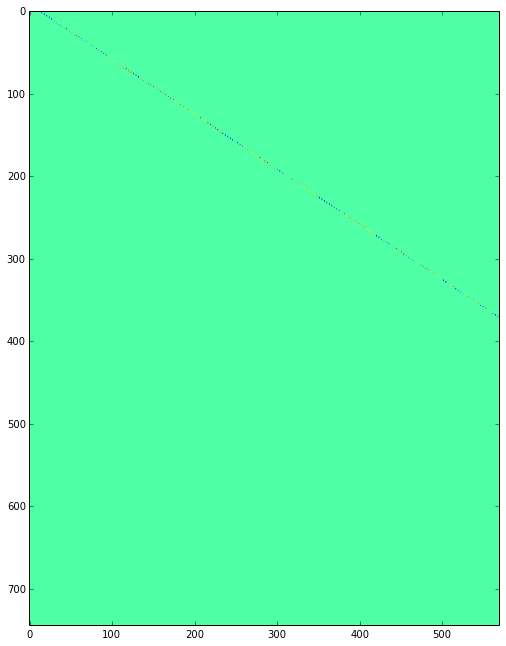

In [147]:
plt.figure(figsize=(15, 11))
plt.imshow(A)
plt.show()

In [148]:
for i in range(img1Matches.shape[1]):
	
	dYr = 0.005
	dZr = 0.005
	dOr = 0.5
	dpr = 0.5
	dkr = 0.5
	
	dXP = 0.005
	dYP = 0.005
	dZP = 0.005

	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,Or+dOr,pr,kr,Xr,Yr,Zr,img1Matches[0,i],img1Matches[1,i],0) 
	fl,gl = computeCollinearity(f,cx,cy,Or-dOr,pr,kr,Xr,Yr,Zr,img1Matches[0,i],img1Matches[1,i],0)

	A[2*i+2*img1Matches.shape[1],9] = (fr - fl)/dOr
	A[2*i+1+2*img1Matches.shape[1],9] = (gr - gl)/dOr
	
	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,Or,pr+dpr,kr,Xr,Yr,Zr,img1Matches[0,i],img1Matches[1,i],0) 
	fl,gl = computeCollinearity(f,cx,cy,Or,pr-dpr,kr,Xr,Yr,Zr,img1Matches[0,i],img1Matches[1,i],0)
	
	A[2*i+2*img1Matches.shape[1],10] = (fr - fl)/dpr
	A[2*i+1+2*img1Matches.shape[1],10] = (gr - gl)/dpr
	
	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,Or,pr,kr+dkr,Xr,Yr,Zr,img1Matches[0,i],img1Matches[1,i],0) 
	fl,gl = computeCollinearity(f,cx,cy,Or,pr,kr+dkr,Xr,Yr,Zr,img1Matches[0,i],img1Matches[1,i],0)
	
	A[2*i+2*img1Matches.shape[1],11] = (fr - fl)/dkr
	A[2*i+1+2*img1Matches.shape[1],11] = (gr - gl)/dkr
	
	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,Or,pr,kr,Xr,Yr+dYr,Zr,img1Matches[0,i],img1Matches[1,i],0) 
	fl,gl = computeCollinearity(f,cx,cy,Or,pr,kr,Xr,Yr-dYr,Zr,img1Matches[0,i],img1Matches[1,i],0)
	
	A[2*i+2*img1Matches.shape[1],7] = (fr - fl)/dYr
	A[2*i+1+2*img1Matches.shape[1],7] = (gr - gl)/dYr
	
	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,Or,pr,kr,Xr,Yr,Zr+dZr,img1Matches[0,i],img1Matches[1,i],0) 
	fl,gl = computeCollinearity(f,cx,cy,Or,pr,kr,Xr,Yr,Zr+dZr,img1Matches[0,i],img1Matches[1,i],0)
	
	A[2*i+2*img1Matches.shape[1],8] = (fr - fl)/dZr
	A[2*i+1+2*img1Matches.shape[1],8] = (gr - gl)/dZr
	
	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,Or,pr,kr,Xr,Yr,Zr,img1Matches[0,i]+dXP,img1Matches[1,i],0) 
	fl,gl = computeCollinearity(f,cx,cy,Or,pr,kr,Xr,Yr,Zr,img1Matches[0,i]-dXP,img1Matches[1,i],0)
	
	A[2*i+2*img1Matches.shape[1],3*i+12] = (fr - fl)/dXP
	A[2*i+1+2*img1Matches.shape[1],3*i+12] = (gr - gl)/dXP
		
	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,Or,pr,kr,Xr,Yr,Zr,img1Matches[0,i],img1Matches[1,i]+dYP,0) 
	fl,gl = computeCollinearity(f,cx,cy,Or,pr,kr,Xr,Yr,Zr,img1Matches[0,i],img1Matches[1,i]-dYP,0)
	
	A[2*i+2*img1Matches.shape[1],3*i+13] = (fr - fl)/dYP
	A[2*i+1+2*img1Matches.shape[1],3*i+13] = (gr - gl)/dYP
		
	#f,x,y,ohm,phi,kap,X,Y,Z,XP,YP,ZP
	fr,gr = computeCollinearity(f,cx,cy,Or,pr,kr,Xr,Yr,Zr,img1Matches[0,i],img1Matches[1,i],0+dZP) 
	fl,gl = computeCollinearity(f,cx,cy,Or,pr,kr,Xr,Yr,Zr,img1Matches[0,i],img1Matches[1,i],0-dZP)
	
	A[2*i+2*img1Matches.shape[1],3*i+14] = (fr - fl)/dZP
	A[2*i+1+2*img1Matches.shape[1],3*i+14] = (gr - gl)/dZP

	ptCalc = computeCollinearity(f,cx,cy,ol,pl,kl,Xl,Yl,Zl,img1Matches[0,i],img1Matches[1,i],0)
	l.append(img2Matches[0,i] - ptCalc[0])
	l.append(img2Matches[1,i] - ptCalc[1])

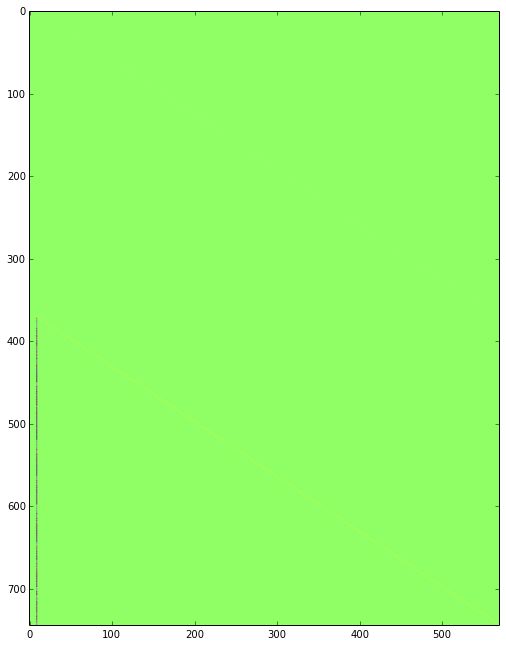

In [149]:
plt.figure(figsize=(15, 11))
plt.imshow(A)
plt.show()

In [150]:
A[2*img1Matches.shape[1]:].max()

20.900590668547011

In [151]:
l = np.array(l)
x = np.array(x)
N = np.dot(A.T,A)

In [152]:
Nsvd = np.linalg.svd(N)
Ninv = np.dot(Nsvd[2].T,np.dot(np.diag(1.0/Nsvd[1]),Nsvd[0].T))
dx = np.dot(Ninv,np.dot(A.T,l))
X = x + dx

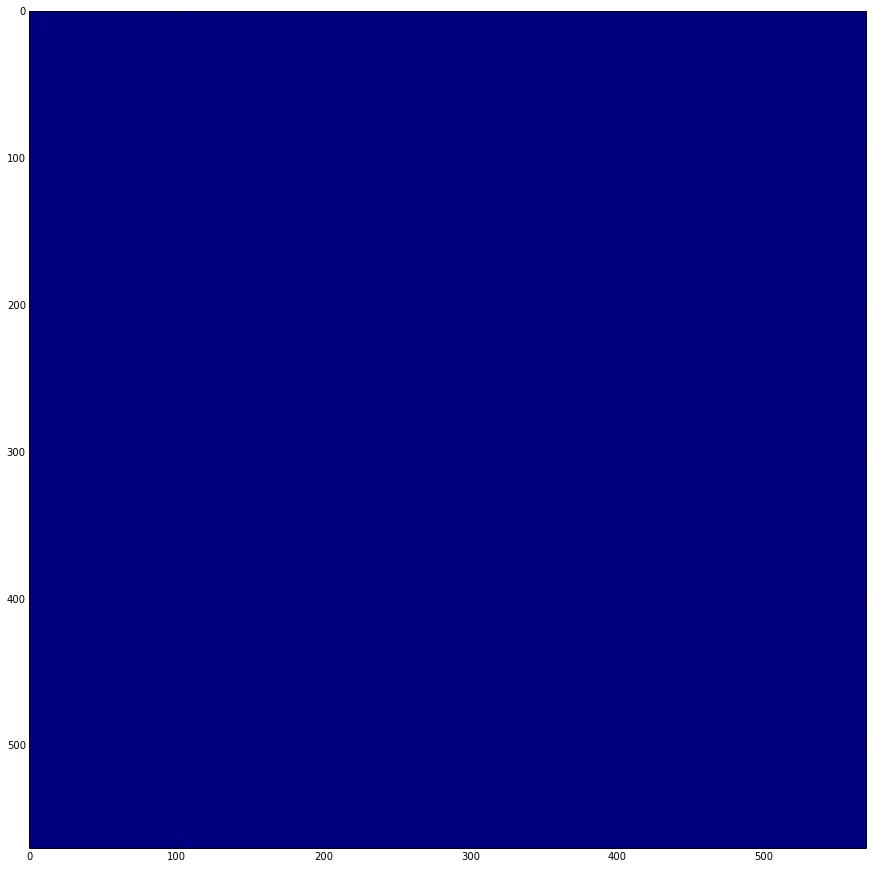

In [153]:
plt.figure(figsize=(15, 15))
plt.imshow(N)
plt.show()

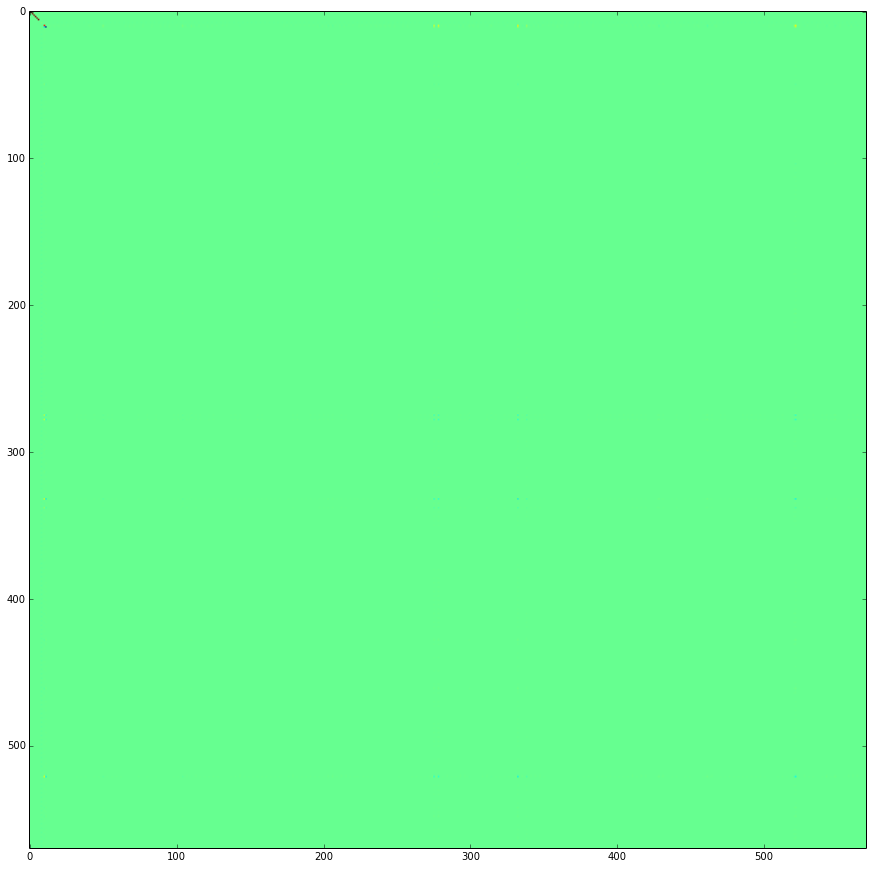

In [154]:
plt.figure(figsize=(15, 15))
plt.imshow(Ninv)
plt.show()

In [155]:
X

array([  0.00000000e+00,   0.00000000e+00,   4.27913700e+02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   4.04456787e+01,   5.56463444e+02,
        -9.83005974e-01,  -5.76782227e-02,  -8.74176025e-02,
        -6.79256301e+01,  -7.82538147e+01,   1.49874051e+01,
        -9.47931346e+01,  -7.41039124e+01,   1.39170732e+01,
        -9.47931346e+01,  -7.41040344e+01,   1.39170723e+01,
        -1.65567674e+02,  -5.72670441e+01,   1.13981338e+01,
        -1.63667588e+02,  -4.63772125e+01,   1.09176704e+01,
        -1.57721214e+02,  -3.97687073e+01,   1.09780170e+01,
         6.94213547e+01,  -3.98775330e+01,   2.74255526e+01,
         5.94546798e+01,  -3.33356476e+01,   3.45072646e+01,
         6.80785860e+01,  -2.85594864e+01,   3.04137487e+01,
        -3.50134159e+01,  -2.90290375e+01,  -1.27164793e+01,
         6.72096291e+01,  -1.26708450e+01,   3.46300199e+01,
         1.68154682e+02,  -1.79599228e+01,  -4.68922853e-02,
        -1.07933585e+01,

In [156]:
X[12:].min()

-2015.3547210693359

In [157]:
v = l - np.dot(A,X)

In [158]:
np.sqrt(np.dot(v.T,v)/(A.shape[0]-A.shape[1]))

293.68306857359755